# Анализ отзывов на банки

# Описание задания

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

# Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

2024-02-02 17:02:34.682583: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-02 17:02:34.710698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Проверка среды на наличие GPU

In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


2024-02-02 17:02:35.582072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 17:02:35.587826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 17:02:35.587978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

#Импорт датасета

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
import gzip
with gzip.open('data/data.csv.gz', 'rt', newline='') as csv_file:
    csv_data = csv_file.read()
    with open('data/data.csv', 'wt') as out_file:
         out_file.write(csv_data)

In [5]:
df = pd.read_csv('data/data.csv',sep=',')
df.head()

,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92735 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92735 non-null  object
 1   title      92735 non-null  object
 2   rating     92735 non-null  int64 
 3   bank_name  92735 non-null  object
 4   date       92735 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.5+ MB
None


In [7]:
print(df.describe())

             rating
count  92735.000000
mean       4.064086
std        1.620702
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000


В ходе анализа датасет содержит отзывы о банках, представленные в пяти колонках: 'body', 'title', 'rating', 'bank_name' и 'date'.Рейтинг отзывов варьируется от 1 до 5.

# EDA (Exploratory Data Analysis)

Определим топ 15 банков по числу отзывов

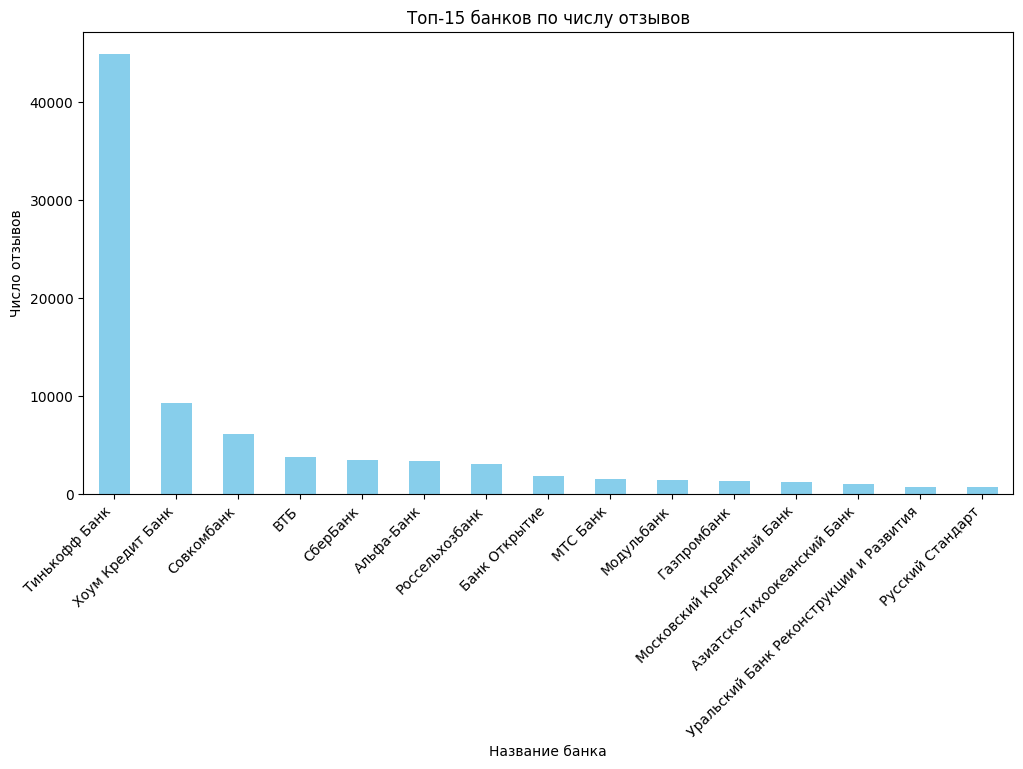

In [8]:
top_banks = df['bank_name'].value_counts().head(15)
plt.figure(figsize=(12, 6))
top_banks.plot(kind='bar', color='skyblue')
plt.title('Топ-15 банков по числу отзывов')
plt.xlabel('Название банка')
plt.ylabel('Число отзывов')
plt.xticks(rotation=45, ha='right')
plt.show()

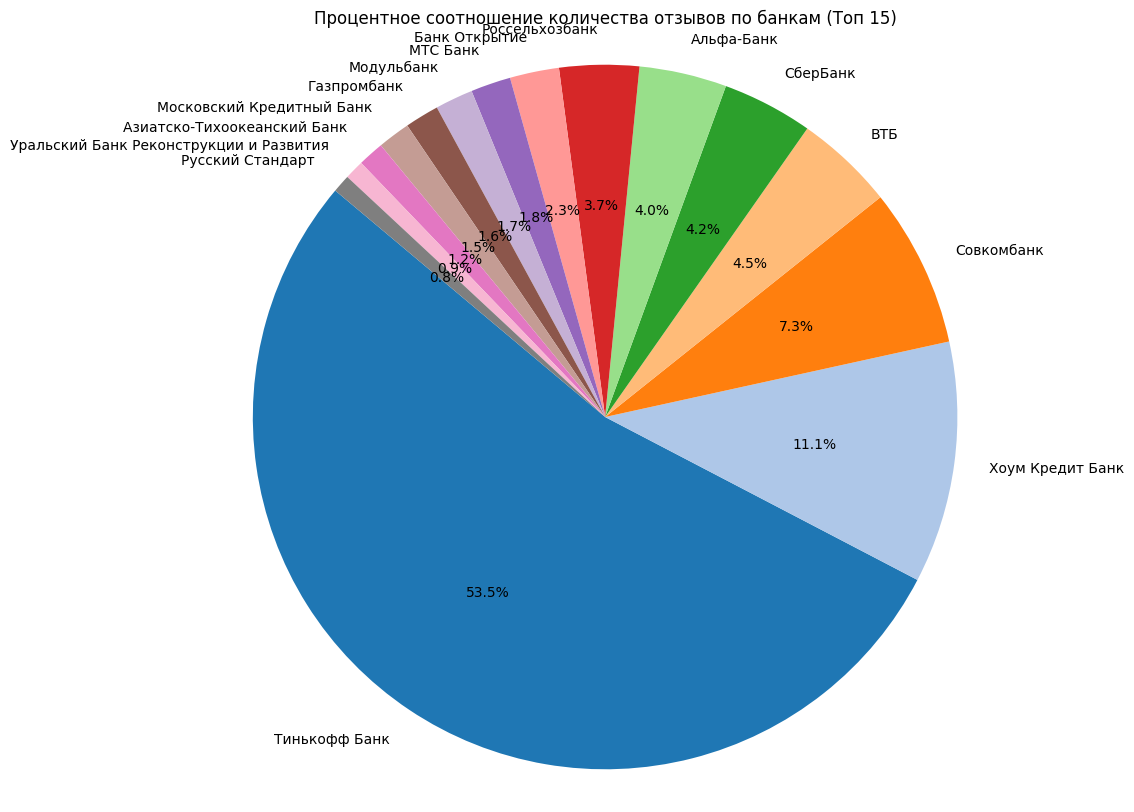

In [9]:
top_review = df.groupby(
    'bank_name'
    ).rating.agg(
        ['count', 'min', 'max']
    ).sort_values(
        'count', ascending=False
    )
top_review = top_review.head(15)

plt.figure(figsize=(10, 10))
plt.pie(top_review['count'], labels=top_review.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Процентное соотношение количества отзывов по банкам (Топ 15)')
plt.axis('equal')
plt.show()

По данным диаграммы и таблицы можно сделать вывод, что наибольшее количество отзывов было оставлено о банке "Тинькофф Банк".

Далее посмотрим количество оценок в целом

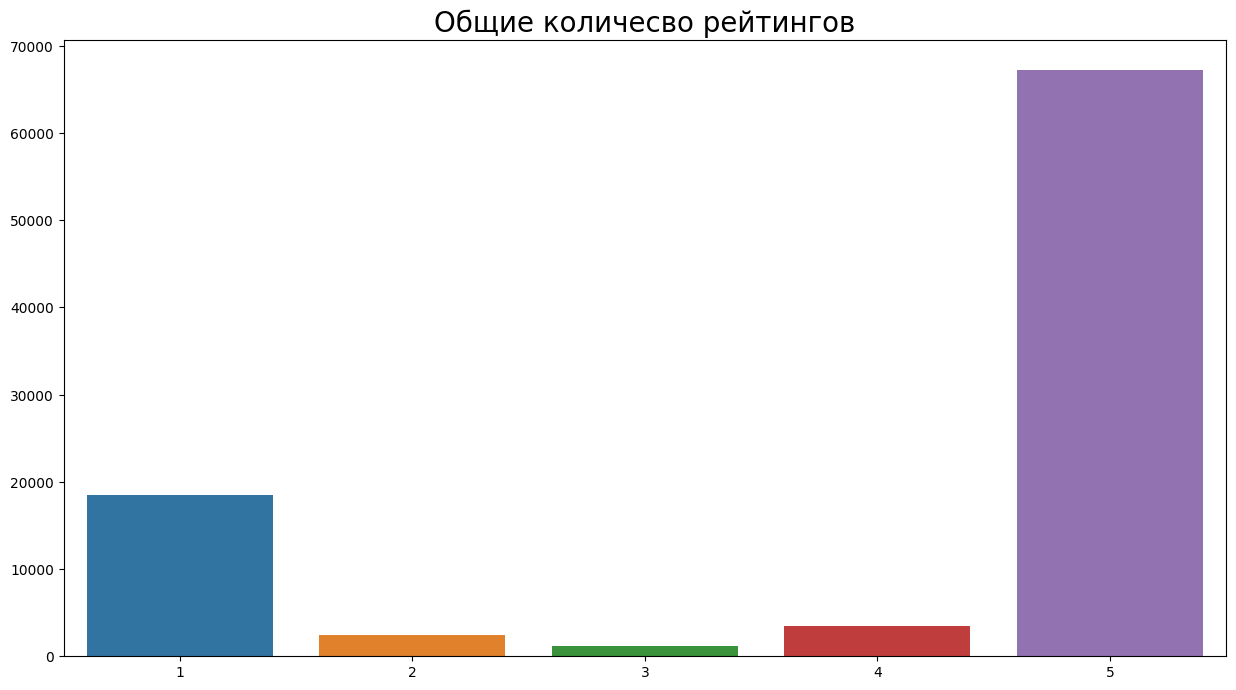

In [10]:
plt.figure(figsize=(15, 8))
plt.title('Общие количесво рейтингов', fontsize=20)

distribution = df['rating'].value_counts().sort_values()
sns.barplot(x=list(distribution.keys()),
            y=distribution.values);

Заметим, что количество оценки 5 анамально много для задачи классификации.

Далее ответим на вопрос "Какой банк из числа топ-15 по отзывам имеет самый высокий средний рейтинг?"

In [11]:
top_15_banks = df['bank_name'].value_counts().head(15).index
top_15_df = df[df['bank_name'].isin(top_15_banks)]
average_ratings = top_15_df.groupby('bank_name')['rating'].mean()
highest_rated_bank = average_ratings.idxmax()
highest_average_rating = average_ratings.max()
print(f"Банк '{highest_rated_bank}' имеет самый высокий средний рейтинг: {highest_average_rating:.2f}")

Банк 'Тинькофф Банк' имеет самый высокий средний рейтинг: 4.78


Проанализируем данные об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов

In [12]:
# Преобразуем столбец "date" в тип datetime
df['date'] = pd.to_datetime(df['date'])

# Добавим столбцы "year" и "month" для анализа
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

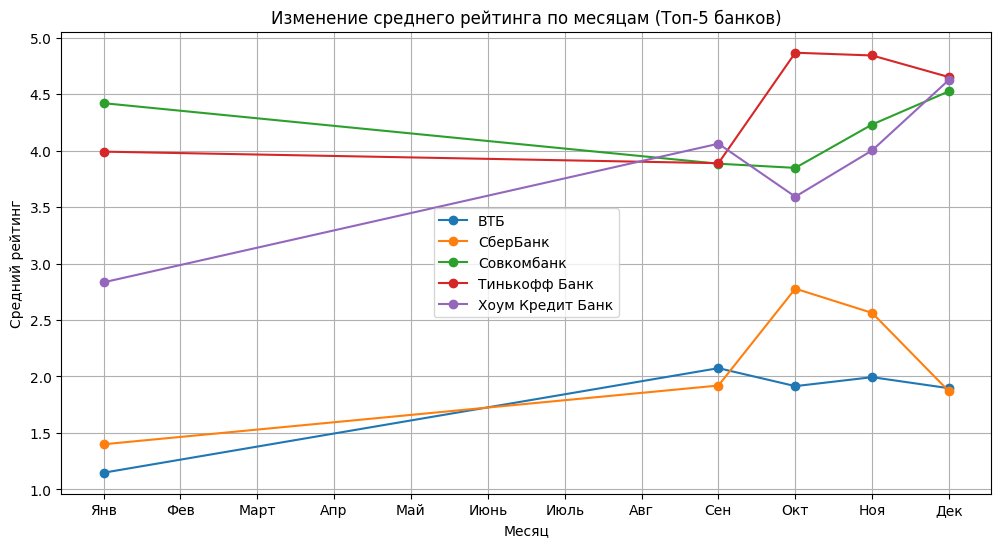

In [13]:
#Выбираем топ-5 банков по числу отзывов
top_5_banks = df['bank_name'].value_counts().head(5).index

#Группируем данные по месяцам и банкам
grouped_data = df[df['bank_name'].isin(top_5_banks)].groupby(['bank_name', 'month'])

#Вычисляем средний рейтинг для каждого месяца и каждого банка
average_rating_by_month = grouped_data['rating'].mean().unstack(level=0)

#Визуализируем изменение среднего рейтинга для каждого банка по месяцам
plt.figure(figsize=(12, 6))
for bank in average_rating_by_month.columns:
    plt.plot(average_rating_by_month.index, average_rating_by_month[bank], marker='o', label=bank)

plt.title('Изменение среднего рейтинга по месяцам (Топ-5 банков)')
plt.xlabel('Месяц')
plt.ylabel('Средний рейтинг')
plt.xticks(range(1, 13), ['Янв', 'Фев', 'Март', 'Апр', 'Май', 'Июнь', 'Июль', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.legend()
plt.grid(True)
plt.show()

Заметим, что представленные данные есть только за 5 месяцев, что объясняет такое поведение графика.

Так что дальше изучим данные по годам

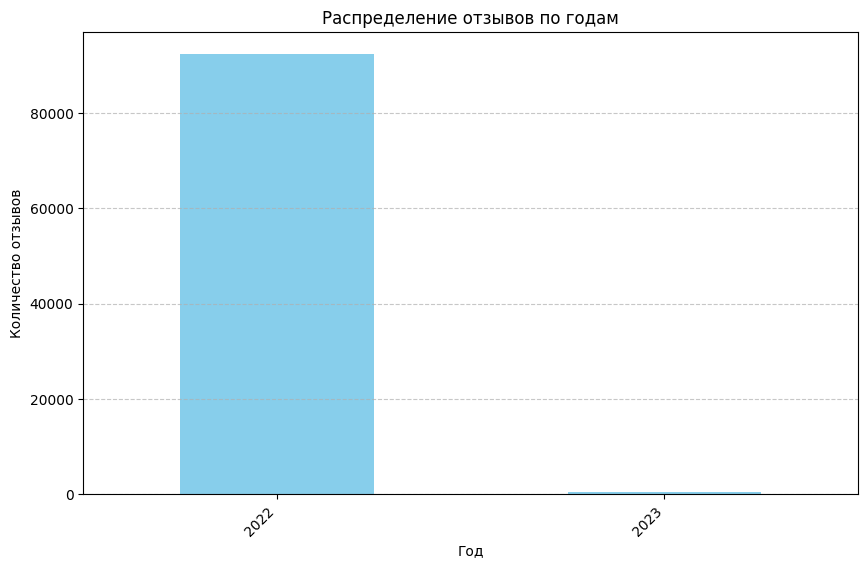

In [14]:
# Построим распределение отзывов по годам
plt.figure(figsize=(10, 6))
df['year'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Распределение отзывов по годам')
plt.xlabel('Год')
plt.ylabel('Количество отзывов')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

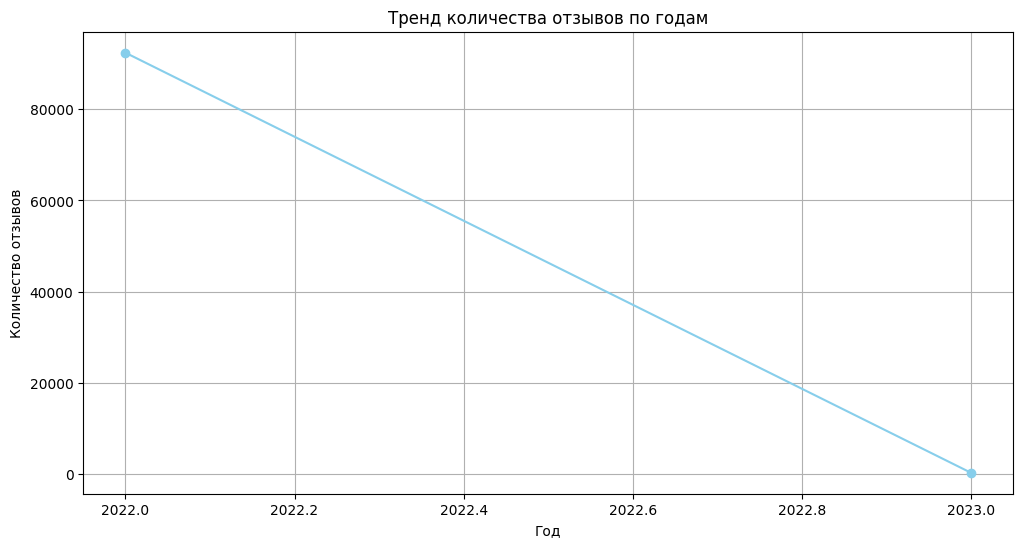

In [15]:
plt.figure(figsize=(12, 6))
df.groupby('year').size().plot(marker='o', color='skyblue')
plt.title('Тренд количества отзывов по годам')
plt.xlabel('Год')
plt.ylabel('Количество отзывов')
plt.grid(True)
plt.show()

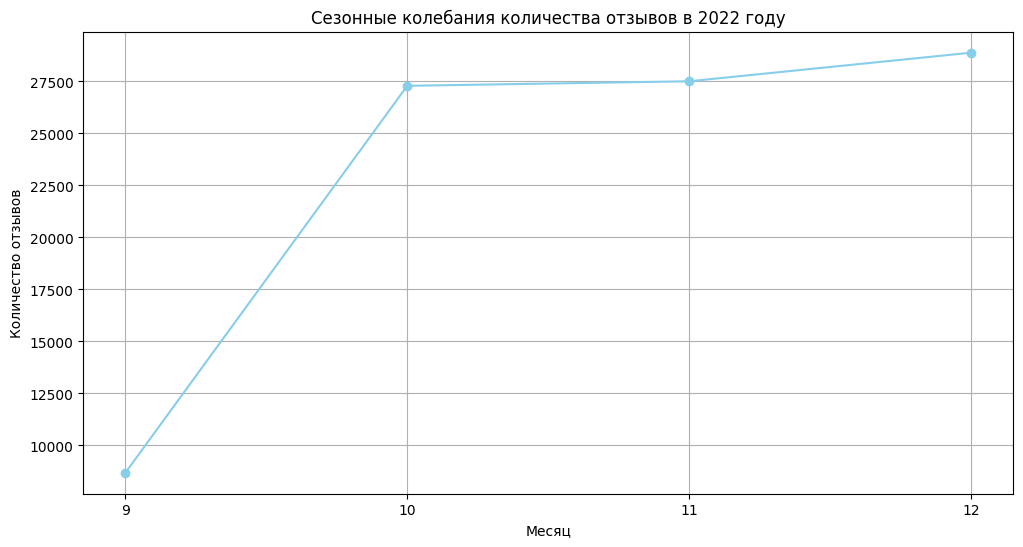

In [16]:
selected_year_df = df[df['year'] == 2022]

# Построение временного ряда количества отзывов по месяцам
plt.figure(figsize=(12, 6))
selected_year_df.groupby('month').size().plot(marker='o', color='skyblue')
plt.title(f'Сезонные колебания количества отзывов в {2022} году')
plt.xlabel('Месяц')
plt.ylabel('Количество отзывов')
plt.xticks(range(9, 13))
plt.grid(True)
plt.show()

Данные охватывают период с сентября по январь с 2022 по 2023 год. Наблюдается наибольшее количество отзывов в период новогодних праздников.

# Подготовка данных для задачи бинарной классификации

Подготовим данные для бинарной классификации для обеспечения баланса между классами в датасете. Проведем undersampling. Для этого определим минимальное количество отзывов для каждого рейтинга и затем случайным образом выбрем такое же количество отзывов для каждого рейтинга, чтобы примерно количество отзывов каждого рейтинга было одинаковым. Таким образом, мы сократили датасет до минимального количества отзывов для каждого рейтинга, обеспечивая балансировку классов.

In [17]:
import pandas as pd
from collections import Counter

min_reviews = min(Counter(df['rating']).values())

undersampled_data = pd.concat([group.sample(min_reviews) for _, group in df.groupby('rating')])
undersampled_data.shape
undersampled_data.reset_index(drop=True, inplace=True)

In [18]:
undersampled_data.head()

,body,title,rating,bank_name,date,year,month
0,Арбитражным судом г.Москвы 30.09.2022 было вын...,Неисполнение банком судебного решения!,1,Альфа-Банк,2022-10-31 17:53:04,2022,10
1,"Итак, началось все с рекламы кредитки 365 дней...",Скатились на дно,1,Альфа-Банк,2022-09-29 11:14:15,2022,9
2,&lt;p&gt;Решил стать клиентом банка открытие и...,Потеряли нового клиента. Халатность представит...,1,Банк Открытие,2022-11-28 21:02:18,2022,11
3,"&lt;p&gt;Всегда был уровень Больше, чем спасиб...",Понизился уровень спасибо,1,СберБанк,2022-12-12 10:14:21,2022,12
4,"&lt;p&gt;Здравствуйте, ситуация такая перевел ...",Не доходят переводы с карты,1,МТС Банк,2022-10-21 19:32:55,2022,10


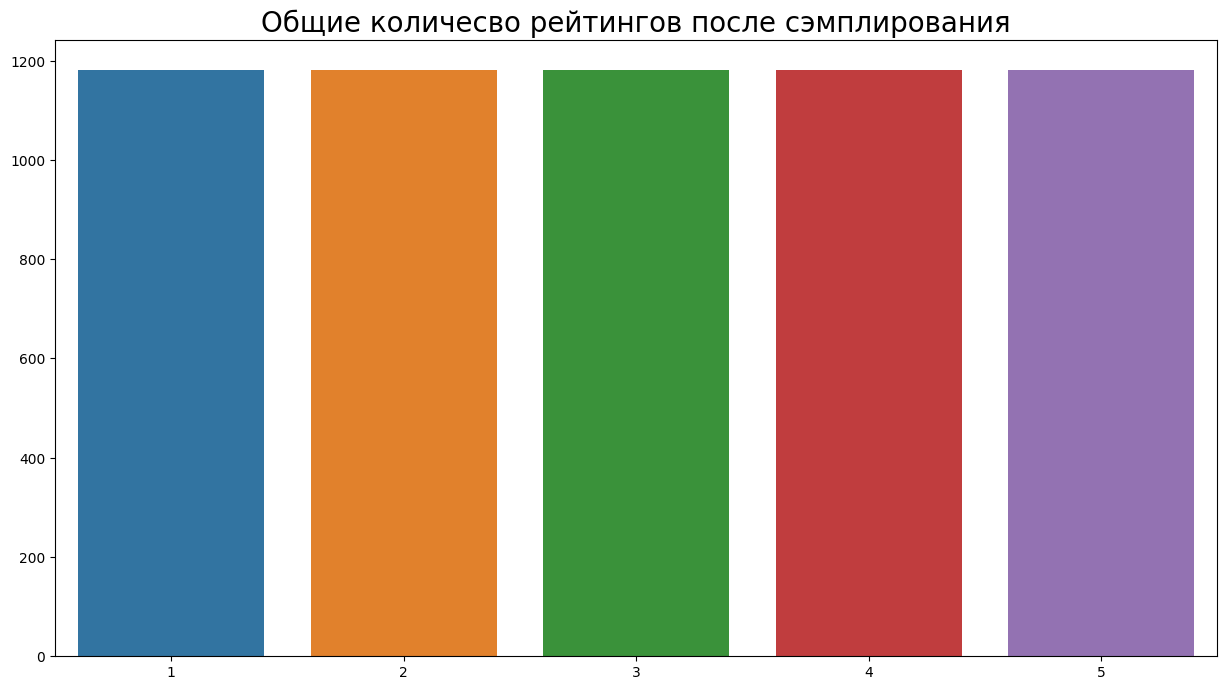

In [19]:
plt.figure(figsize=(15, 8))
plt.title('Общие количесво рейтингов после сэмплирования', fontsize=20)

distribution_undersampled_data = undersampled_data['rating'].value_counts().sort_values()
sns.barplot(x=list(distribution_undersampled_data.keys()),
            y=distribution_undersampled_data.values);

Далее сделаем столбец sentiment, где отзывы >=3 считаем положительными, а <3 - отрицательными)

In [20]:
undersampled_data['sentiment'] = undersampled_data['rating'].apply(lambda x: 'positive' if x >= 3 else 'negative')

undersampled_data.head()

,body,title,rating,bank_name,date,year,month,sentiment
0,Арбитражным судом г.Москвы 30.09.2022 было вын...,Неисполнение банком судебного решения!,1,Альфа-Банк,2022-10-31 17:53:04,2022,10,negative
1,"Итак, началось все с рекламы кредитки 365 дней...",Скатились на дно,1,Альфа-Банк,2022-09-29 11:14:15,2022,9,negative
2,&lt;p&gt;Решил стать клиентом банка открытие и...,Потеряли нового клиента. Халатность представит...,1,Банк Открытие,2022-11-28 21:02:18,2022,11,negative
3,"&lt;p&gt;Всегда был уровень Больше, чем спасиб...",Понизился уровень спасибо,1,СберБанк,2022-12-12 10:14:21,2022,12,negative
4,"&lt;p&gt;Здравствуйте, ситуация такая перевел ...",Не доходят переводы с карты,1,МТС Банк,2022-10-21 19:32:55,2022,10,negative


In [21]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
undersampled_data['sentiment'] = le.fit_transform(undersampled_data['sentiment'])

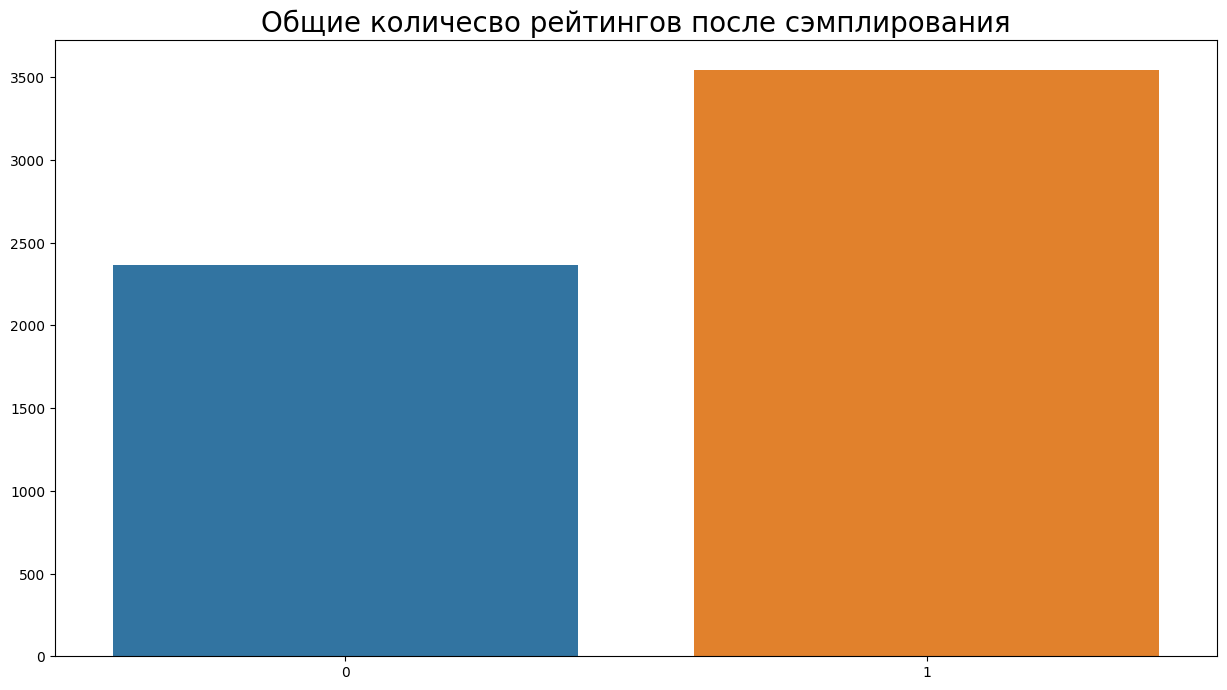

In [22]:
plt.figure(figsize=(15, 8))
plt.title('Общие количесво рейтингов после сэмплирования', fontsize=20)

distribution_undersampled_data = undersampled_data['sentiment'].value_counts().sort_values()
sns.barplot(x=list(distribution_undersampled_data.keys()),
            y=distribution_undersampled_data.values);

In [23]:
!pip3 install transformers

In [24]:
!pip3 install spacy
!python3 -m spacy download ru_core_news_lg

✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')


In [25]:
import nltk
import spacy
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load('ru_core_news_lg')

2024-02-02 17:02:48.751992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 17:02:48.752111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 17:02:48.752174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Напишем функцию clean_string(), которая будет предназначена для предварительной обработки текстовых данных. Она будет приводить текст к нижнему регистру, удалять переносы строк, упоминания пользователей и HTML-теги, декодировать HTML-сущности, удалять пунктуацию, стоп-слова и числа, а также проводит стемминг или лемматизацию слов(по запросу)

In [26]:
import re
import string
import html
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

def clean_string(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'<br />', '', text)

    # Decode HTML entities
    text = html.unescape(text)

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("russian")

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer()
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

In [27]:
print('Original: ', undersampled_data['body'][0])
print('Processed: ', clean_string(undersampled_data['body'][0]))

Original:  Арбитражным судом г.Москвы 30.09.2022 было вынесено решение о разблокировке системы ДБО.  Сегодня 31 октября 2022 решение банком не исполнено. Дело в арбитражном суде за номером №А***22. Данное решение было отправлено по системе ДБО, отнесено нарочно в офис обслуживания, и ответа никакого от банка так и не поступило.
Processed:  арбитражным судом гмосквы  вынесено решение разблокировке системы дбо сегодня  октября  решение банком исполнено дело арбитражном суде номером № данное решение отправлено системе дбо отнесено нарочно офис обслуживания ответа никакого банка поступило


In [28]:
%%time
undersampled_data['summary'] = undersampled_data.apply(lambda row: (row['body'] + '. ' + row['title']), axis=1)
undersampled_data['summary_clean'] = undersampled_data['summary'].apply(clean_string)
undersampled_data.head()

CPU times: user 1.73 s, sys: 20.6 ms, total: 1.75 s
Wall time: 1.75 s


,body,title,rating,bank_name,date,year,month,sentiment,summary,summary_clean
0,Арбитражным судом г.Москвы 30.09.2022 было вын...,Неисполнение банком судебного решения!,1,Альфа-Банк,2022-10-31 17:53:04,2022,10,0,Арбитражным судом г.Москвы 30.09.2022 было вын...,арбитражным судом гмосквы вынесено решение ра...
1,"Итак, началось все с рекламы кредитки 365 дней...",Скатились на дно,1,Альфа-Банк,2022-09-29 11:14:15,2022,9,0,"Итак, началось все с рекламы кредитки 365 дней...",итак началось рекламы кредитки дней процентов...
2,&lt;p&gt;Решил стать клиентом банка открытие и...,Потеряли нового клиента. Халатность представит...,1,Банк Открытие,2022-11-28 21:02:18,2022,11,0,&lt;p&gt;Решил стать клиентом банка открытие и...,решил стать клиентом банка открытие заказал де...
3,"&lt;p&gt;Всегда был уровень Больше, чем спасиб...",Понизился уровень спасибо,1,СберБанк,2022-12-12 10:14:21,2022,12,0,"&lt;p&gt;Всегда был уровень Больше, чем спасиб...",уровень спасибо категории тратам выполнены каж...
4,"&lt;p&gt;Здравствуйте, ситуация такая перевел ...",Не доходят переводы с карты,1,МТС Банк,2022-10-21 19:32:55,2022,10,0,"&lt;p&gt;Здравствуйте, ситуация такая перевел ...",здравствуйте ситуация такая перевел деньги сб...


In [29]:
undersampled_data.shape

(5910, 10)

TF-IDF (Term Frequency-Inverse Document Frequency) - это метод векторизации текстовых данных, который преобразует тексты в числовые векторы. Он учитывает частоту встречаемости слов в документе (TF) и их важность в коллекции документов (IDF). TF-IDF помогает идентифицировать важные слова, учитывать контекст и значимость терминов, а также уменьшать влияние общеупотребительных слов. Использование TF-IDF перед классификацией текстов позволяет улучшить качество модели и учитывать ключевую информацию в тексте.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(undersampled_data['summary_clean'])

In [31]:
from sklearn.model_selection import train_test_split

X = tfidf.toarray()
y = undersampled_data.sentiment.values
print(X.shape, y.shape)

(5910, 46081) (5910,)


In [32]:
# Разделим данные на обучающую (70%) и тестовую (30%) выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import sklearn.metrics as metrics
from sklearn import metrics

Сделаем функцию visualize_classification_results для визуализации результатов классификации. Она будет выводить отчет о классификации, матрицу ошибок (confusion matrix) и кривую ROC (Receiver Operating Characteristic).

В отчете о классификации выводятся метрики precision, recall, F1-score и поддержка для каждого класса. Матрица ошибок демонстрирует количество правильных и неправильных прогнозов модели для каждого класса. Кривая ROC показывает соотношение между долей ложно положительных и истинно положительных результатов при варьировании порога классификации. Эти визуализации помогают оценить производительность модели и ее способность различать классы.

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score

def visualize_classification_results(y_test, y_pred_test, probs):
    # Classification Report
    print(classification_report(y_test, y_pred_test, target_names=['negative', 'positive']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                            index=['Predict Positive', 'Predict Negative'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Confusion Matrix')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

    # ROC Curve
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Анализ бинарных классификаторов

Для анализа задачи "Какой бинарный классификатор подойдет для этой задачи лучше" были использованы следующие модели машинного обучения: Градиентный бустинг, GaussianNB, Дерево решений, MultinomialNB, RandomForestClassifier, Logistic Regression и LinearSVC через CalibratedClassifierCV

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=120, learning_rate = 0.1, max_features=8, max_depth = 7, random_state = 0)
gb.fit(X_train, y_train)
y_pred_train = gb.predict(X_train)
y_pred_test = gb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))


Training Accuracy score: 0.7619047619047619
Testing Accuracy score: 0.6452340665538635


              precision    recall  f1-score   support

    negative       0.73      0.21      0.33       726
    positive       0.63      0.94      0.76      1047

    accuracy                           0.65      1773
   macro avg       0.68      0.58      0.54      1773
weighted avg       0.67      0.65      0.58      1773



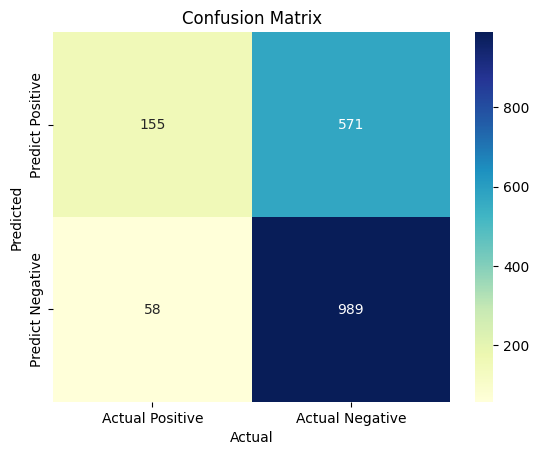

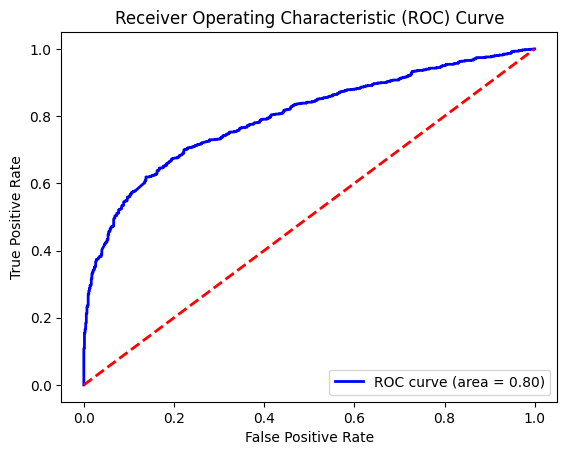

In [36]:
probs = gb.predict_proba(X_test)
visualize_classification_results(y_test, y_pred_test, probs)

In [37]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))


Training Accuracy score: 0.9944404157602127
Testing Accuracy score: 0.6672306824591089


              precision    recall  f1-score   support

    negative       0.58      0.67      0.62       726
    positive       0.75      0.66      0.70      1047

    accuracy                           0.67      1773
   macro avg       0.66      0.67      0.66      1773
weighted avg       0.68      0.67      0.67      1773



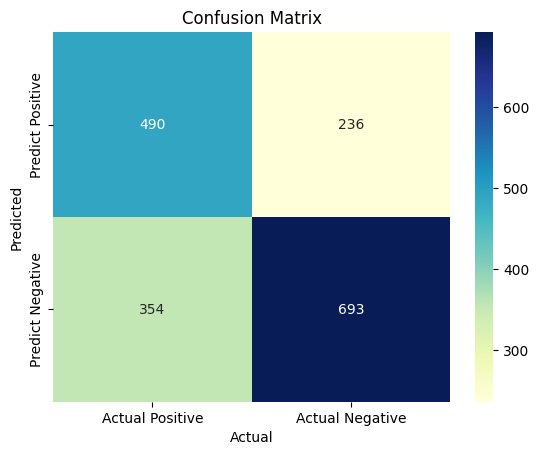

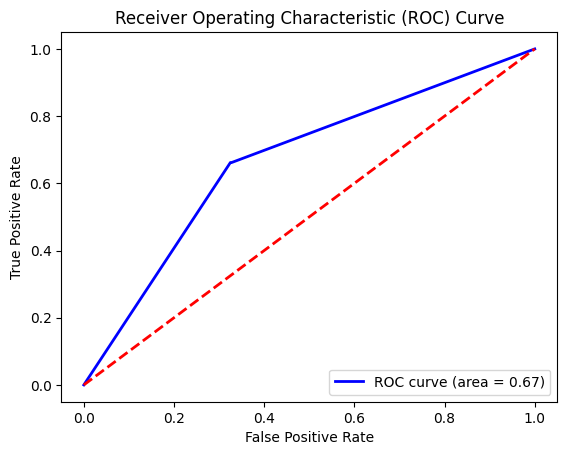

In [38]:
probs = gnb.predict_proba(X_test)
visualize_classification_results(y_test, y_pred_test, probs)

In [39]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
%time
dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs

Training Accuracy score: 1.0
Testing Accuracy score: 0.688663282571912


              precision    recall  f1-score   support

    negative       0.63      0.59      0.61       726
    positive       0.73      0.76      0.74      1047

    accuracy                           0.69      1773
   macro avg       0.68      0.67      0.68      1773
weighted avg       0.69      0.69      0.69      1773



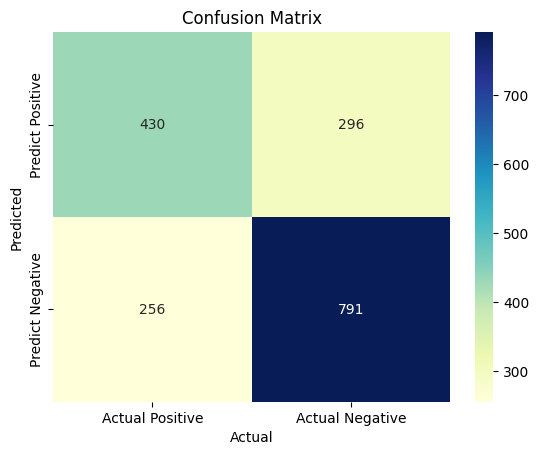

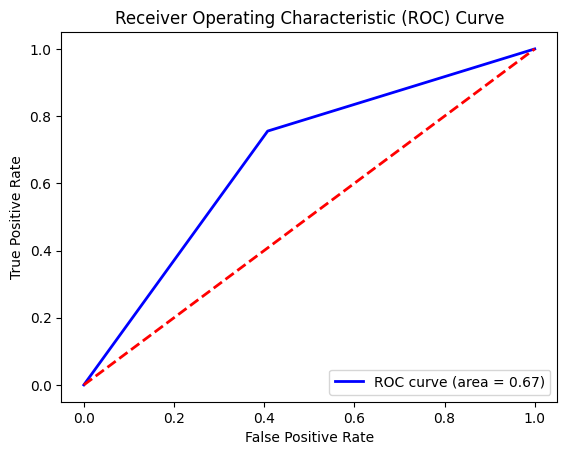

In [40]:
probs = dt.predict_proba(X_test)
visualize_classification_results(y_test, y_pred_test, probs)

In [41]:
mnb = MultinomialNB()
%time
mnb.fit(X_train, y_train)

y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.15 µs

Training Accuracy score: 0.8767222625090645
Testing Accuracy score: 0.7253243090806543


              precision    recall  f1-score   support

    negative       0.77      0.47      0.58       726
    positive       0.71      0.90      0.79      1047

    accuracy                           0.73      1773
   macro avg       0.74      0.69      0.69      1773
weighted avg       0.73      0.73      0.71      1773



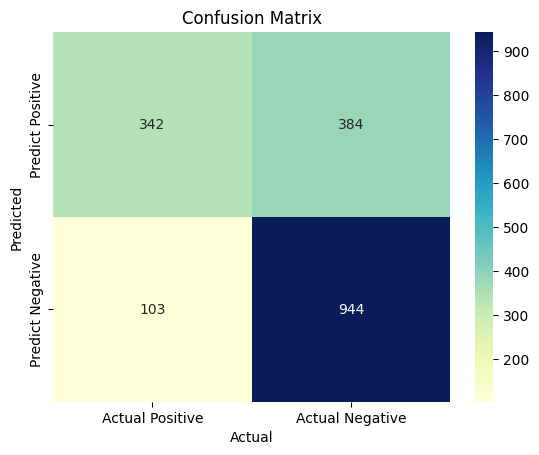

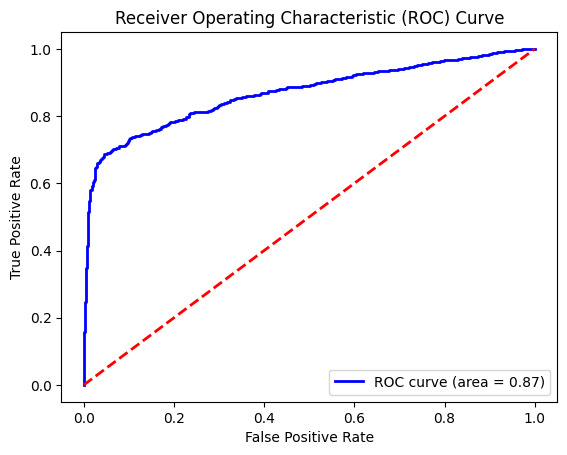

In [42]:
probs = mnb.predict_proba(X_test)
visualize_classification_results(y_test, y_pred_test, probs)

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))


Training Accuracy score: 1.0
Testing Accuracy score: 0.7698815566835872


              precision    recall  f1-score   support

    negative       0.73      0.70      0.71       726
    positive       0.80      0.82      0.81      1047

    accuracy                           0.77      1773
   macro avg       0.76      0.76      0.76      1773
weighted avg       0.77      0.77      0.77      1773



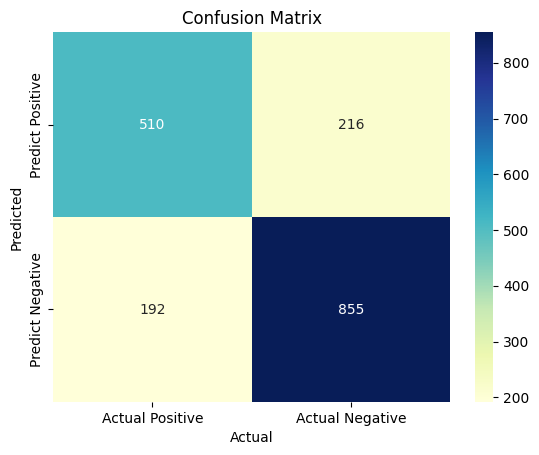

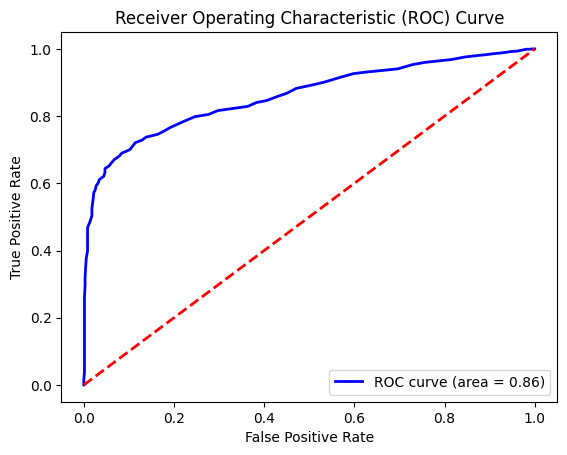

In [44]:
probs = rf.predict_proba(X_test)
visualize_classification_results(y_test, y_pred_test, probs)

In [45]:
lr = LogisticRegression(random_state=42)
%time
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs

Training Accuracy score: 0.9153976311336718
Testing Accuracy score: 0.7772137619853355


              precision    recall  f1-score   support

    negative       0.75      0.69      0.72       726
    positive       0.79      0.84      0.82      1047

    accuracy                           0.78      1773
   macro avg       0.77      0.76      0.77      1773
weighted avg       0.78      0.78      0.78      1773



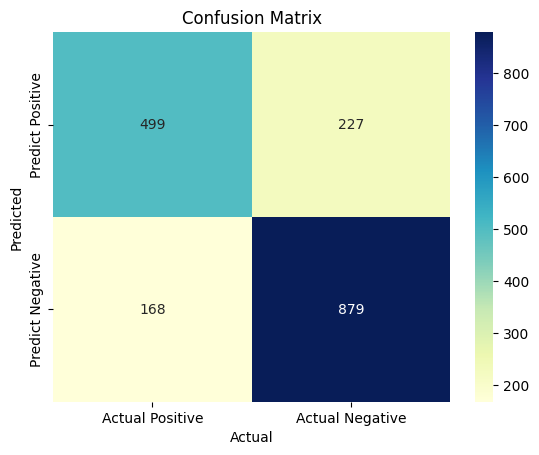

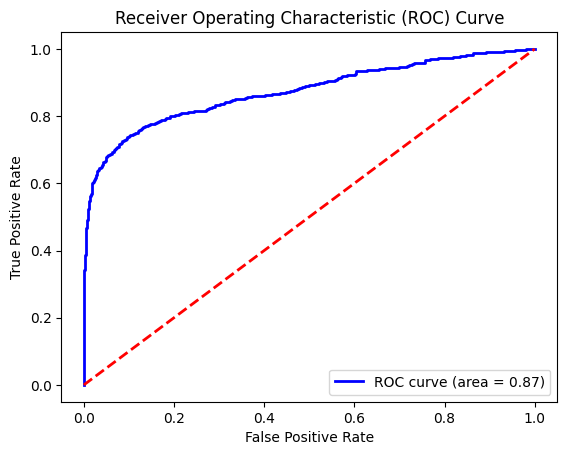

In [46]:
probs = lr.predict_proba(X_test)
visualize_classification_results(y_test, y_pred_test, probs)

In [47]:
from sklearn.calibration import CalibratedClassifierCV
svc =  LinearSVC(class_weight='balanced')
%time
clf = CalibratedClassifierCV(svc)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs

Training Accuracy score: 0.9961324631375392
Testing Accuracy score: 0.787366046249295


              precision    recall  f1-score   support

    negative       0.74      0.75      0.74       726
    positive       0.82      0.82      0.82      1047

    accuracy                           0.79      1773
   macro avg       0.78      0.78      0.78      1773
weighted avg       0.79      0.79      0.79      1773



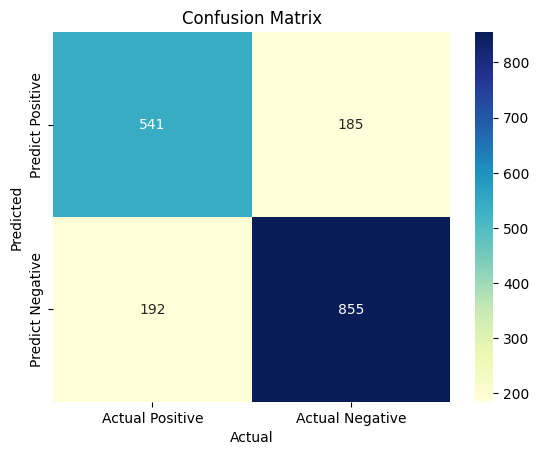

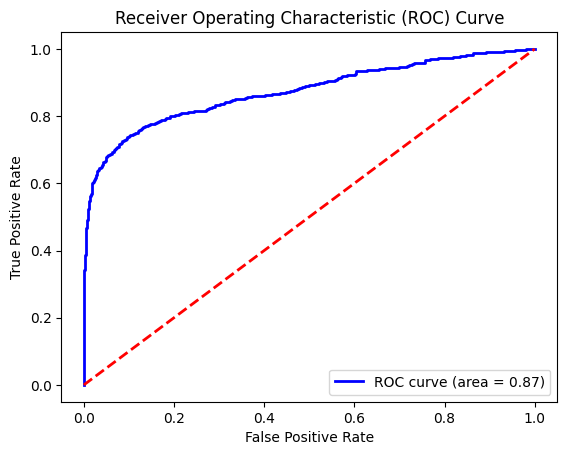

In [48]:
y_proba = clf.predict_proba(X_test)
visualize_classification_results(y_test, y_pred_test, probs)

# Выводы

Из проведенного анализа видно, что различные модели машинного обучения проявляют разную эффективность в решении задачи бинарной классификации отзывов. Среди всех моделей LinearSVC через CalibratedClassifierCV показала наилучшие результаты по всем метрикам: precision, recall и f1-score. Это указывает на то, что данная модель хорошо справляется с предсказанием обеих классов и обладает хорошей обобщающей способностью.